https://www.kaggle.com/paulorzp/gmean-of-light-gbm-models-lb-0-95x

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

In [4]:
all_files = ['./data/sub_feat457_modelselect.csv',
             './data/sub_feat454_rmcardid_modelselect.csv',
            './data/sub_feat448_modelselect.csv',
            './data/sub_feat469_rm1_modelselect.csv',
            './data/sub_feat476_modelselect.csv']

In [5]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in range(0,len(all_files))]
all_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "sub" + str(x), range(len(all_sub.columns))))
all_sub.columns = cols
all_sub.reset_index(inplace=True)

In [6]:
all_sub.head()

,TransactionID,sub0,sub1,sub2,sub3,sub4
0,3663549,0.001578,0.000918,0.000366,0.001202,0.002719
1,3663550,0.000631,0.001581,0.001019,0.000588,0.001117
2,3663551,0.001217,0.001058,0.000492,0.000967,0.002041
3,3663552,0.001046,0.000984,0.000427,0.001072,0.002194
4,3663553,0.000626,0.001002,0.000398,0.000376,0.000856


In [7]:
# calculate correlation of submissions
corr = all_sub.iloc[:,1:].corr()

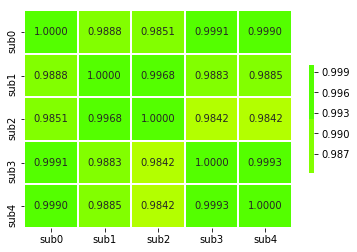

In [8]:
sns.heatmap(corr,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Weighted GMEAN by inverse correlation

In [9]:
corr_rank = np.tril(all_sub.iloc[:,1:].corr().values,0)+np.triu(np.ones(corr.shape),1)
corr_rank

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.98879574, 1.        , 1.        , 1.        , 1.        ],
       [0.98506865, 0.99680381, 1.        , 1.        , 1.        ],
       [0.9990538 , 0.98828896, 0.9841923 , 1.        , 1.        ],
       [0.99901533, 0.98850658, 0.98423407, 0.99933737, 1.        ]])

In [10]:
# calculate how many times of blend is needed
blend_times = (corr_rank>0).sum() - (corr_rank>0.99).sum()
blend_times

6

In [11]:
m_gmean, weight_sum = 0, 0

In [12]:
# https://en.wikipedia.org/wiki/Weighted_geometric_mean
for i in range(blend_times):
    min_corr_indexs = np.unravel_index(corr_rank.argmin(), corr_rank.shape)
    print('%s round with current minimual index%s'%(i,min_corr_indexs))
    # weight decay with higher correlations
    weight = (blend_times-i)/blend_times
    m_gmean += weight*(np.log(all_sub.iloc[:,min_corr_indexs[0]+1])+np.log(all_sub.iloc[:,min_corr_indexs[1]+1]))/2
    print(m_gmean.head())
    weight_sum += weight
    print('current weight:%s, total weight:%s'%(weight,weight_sum))
    corr_rank[min_corr_indexs] = 1
    print(corr_rank)

0 round with current minimual index(3, 2)
0   -7.318984
1   -7.164062
2   -7.278531
3   -7.298228
4   -7.857806
dtype: float64
current weight:1.0, total weight:1.0
[[1.         1.         1.         1.         1.        ]
 [0.98879574 1.         1.         1.         1.        ]
 [0.98506865 0.99680381 1.         1.         1.        ]
 [0.9990538  0.98828896 1.         1.         1.        ]
 [0.99901533 0.98850658 0.98423407 0.99933737 1.        ]]
1 round with current minimual index(4, 2)
0   -13.077957
1   -12.866738
2   -13.032938
3   -13.081793
4   -14.063293
dtype: float64
current weight:0.8333333333333334, total weight:1.8333333333333335
[[1.         1.         1.         1.         1.        ]
 [0.98879574 1.         1.         1.         1.        ]
 [0.98506865 0.99680381 1.         1.         1.        ]
 [0.9990538  0.98828896 1.         1.         1.        ]
 [0.99901533 0.98850658 1.         0.99933737 1.        ]]
2 round with current minimual index(2, 0)
0   -17.86641

In [13]:
m_gmean = np.exp(m_gmean/weight_sum)
m_gmean.head()

0    0.000895
1    0.000925
2    0.000896
3    0.000857
4    0.000538
dtype: float64

In [14]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
m_gmean.head()

0    0.000689
1    0.000716
2    0.000691
3    0.000655
4    0.000371
dtype: float64

In [15]:
all_sub['isFraud'] = m_gmean
all_sub.tail()

,TransactionID,sub0,sub1,sub2,sub3,sub4,isFraud
506686,4170235,0.005848,0.007015,0.002817,0.005570,0.010515,0.004395
506687,4170236,0.002687,0.004152,0.002658,0.002492,0.005402,0.002701
506688,4170237,0.002786,0.005243,0.003182,0.002671,0.006003,0.003106
506689,4170238,0.002308,0.002355,0.001059,0.002249,0.004420,0.001624
506690,4170239,0.003451,0.003530,0.002144,0.004425,0.008817,0.003106


In [16]:
all_sub[['TransactionID','isFraud']].to_csv('./data/sub_5stack_gmean.csv',index=False)